In [1]:
%%HTML
<style>
    /* style for presentation only */
    .reveal .rendered_html table { font-size: 24px }
</style> 

# Cartography with Python
Setup

In [51]:
import pip
#pip.main("install -q osmnx matplotlib pandas geopandas shapely descartes".split())
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Point
from descartes import PolygonPatch
import pandas as pd
import numpy as np
import geopandas as gpd
cmap=plt.cm.get_cmap('jet')
from matplotlib import colors as colors
from matplotlib import colorbar 
from IPython.display import display
points = {
    'belfast':(54.5973, -5.9301),
    'farset': (54.592789, -5.940715),
    'dublin':(53.3498, -6.2603),
    'napa':(38.294073,-122.2951242)
}
dist = 2000 # metres 
figsize = 12

%matplotlib inline

# Basic Mapping with OSMNX

In [52]:
# get the network within 1km north, south, east, and west of the point, then project to UTM
G = ox.graph_from_point(points['farset'], distance=dist, distance_type='bbox', 
                        network_type='all', truncate_by_edge=False)
G = ox.project_graph(G)
# create the plot's bounding box in meters to limit the plot to the square mile bounding box requested
# this is only necessary when truncate_by_edge=True to prevent display of nodes/edges that extend beyond bounding box
bbox_proj = ox.bbox_from_point(points['farset'], dist*0.8, project_utm=True)

# plot the graph and save it to disk
fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=32, node_color='b',
                        edge_linewidth=2, file_format='png', edge_color='w', bgcolor='#47494c', 
                        show=False)

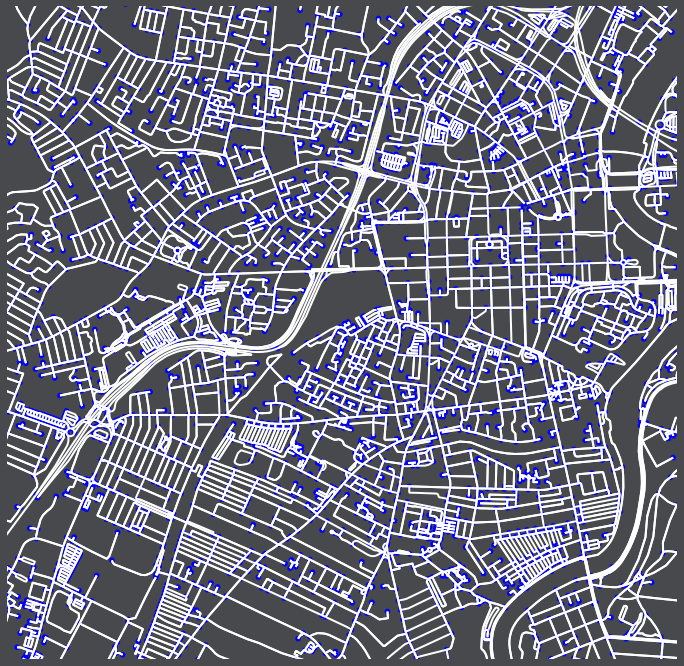

In [53]:
fig

## So what else is there?
OpenStreetMap has a wealth of information available on the nature of roads and paths

In [54]:
for u, v, key, data in G.edges(keys=True, data=True):
    print(u,v,key,data)
    break

3661561863 3661550487 0 {'osmid': 318689969, 'oneway': True, 'name': 'Brougham Street', 'highway': 'tertiary', 'length': 52.947, 'geometry': <shapely.geometry.linestring.LineString object at 0x12cc38860>}


In [55]:
edges = []
for u, v, key, data in G.edges(keys=True, data=True):
    edge = dict(
        u=u,
        v=v,
        key=key
    )
    edge.update(data)
    edges.append(edge)
df = pd.DataFrame.from_records(edges)
df.head()

access area bridge                                           geometry  \
0    NaN  NaN    NaN  LINESTRING (311150.8413480546 6055331.75993183...   
1    NaN  NaN    NaN  LINESTRING (311150.8413480546 6055331.75993183...   
2    NaN  NaN    NaN  LINESTRING (311238.9427430433 6055361.41657749...   
3    NaN  NaN    NaN  LINESTRING (311238.9427430433 6055361.41657749...   
4    NaN  NaN    NaN  LINESTRING (311189.8875807914 6055269.87973195...   

         highway junction  key lanes   length maxspeed             name  \
0       tertiary      NaN    0   NaN   52.947      NaN  Brougham Street   
1  tertiary_link      NaN    0   NaN   64.861      NaN              NaN   
2  tertiary_link      NaN    0   NaN   80.615   30 mph              NaN   
3          trunk      NaN    0     2   71.362   30 mph      York Street   
4          trunk      NaN    0     1  148.321   30 mph      York Street   

   oneway      osmid  ref service tunnel           u           v width  
0    True  318689969  NaN     NaN    NaN  3661561863  3661550487   NaN  
1    True  361711668  NaN     NaN    NaN  3661561863  1646867260   NaN  
2    True  361711669  NaN     NaN    NaN  3661561864  3661550486   NaN  
3    True  545372189   A2     NaN    NaN  3661561864  3661550483   NaN  
4    True  400789832   A2     NaN    NaN  3661561865  1646867256   NaN

In [56]:
df.dtypes

access       object
area         object
bridge       object
geometry     object
highway      object
junction     object
key           int64
lanes        object
length      float64
maxspeed     object
name         object
oneway         bool
osmid        object
ref          object
service      object
tunnel       object
u             int64
v             int64
width        object
dtype: object

In [57]:
objects = (df.dtypes==object)
objects

access       True
area         True
bridge       True
geometry     True
highway      True
junction     True
key         False
lanes        True
length      False
maxspeed     True
name         True
oneway      False
osmid        True
ref          True
service      True
tunnel       True
u           False
v           False
width        True
dtype: bool

In [58]:
uniques = {}
for c in df[objects[objects].index]:
    try:
        uniques[c] = df[c].unique()
    except TypeError:
        print("Can't unique on {}".format(c))
uniques

Can't unique on access
Can't unique on geometry
Can't unique on highway
Can't unique on lanes
Can't unique on maxspeed
Can't unique on name
Can't unique on osmid


{'area': array([nan, 'no'], dtype=object),
 'bridge': array([nan, 'yes', 'movable'], dtype=object),
 'junction': array([nan, 'roundabout'], dtype=object),
 'ref': array([nan, 'A2', 'A501', 'A1', 'B506', 'B23', 'A24', 'C703', 'A20',
        'B503', 'C702', 'A11', 'B126', 'A52', 'B502', 'B39', 'B38', 'A12',
        'A6', 'M1', 'A23', 'A55', 'M2', 'M3', 'B505'], dtype=object),
 'service': array([nan, 'parking_aisle', 'emergency_access', 'alley', 'driveway',
        'drive-through', 'bus'], dtype=object),
 'tunnel': array([nan, 'building_passage', 'yes', 'covered'], dtype=object),
 'width': array([nan, '2', '1', 'narrow'], dtype=object)}

In [59]:
df['width'] = df.width.apply(lambda l: l if isinstance(l,list) or l !='narrow' else '0.5')

In [60]:
df['width'] = df['width'].apply(lambda l: max(map(float,l)) if isinstance(l,list) else float(l))
df['lanes'] = df['lanes'].apply(lambda l: max(map(float,l)) if isinstance(l,list) else float(l))
#df['bridge'] = df['bridge'] == 'yes'
#df['area'] = df['area'] != 'no'
df['maxspeed'] = df['maxspeed'].apply(
    lambda s: float(
        ''.join([
            c for c in s if c.isdigit()
        ])) 
    if isinstance(s,str) else None)

# Plotting with Values
## Speed Limits

In [61]:
df['maxspeed'].unique()

array([nan, 30., 20., 50., 40., 10.])

In [62]:
def maxspeed_colormap(f):
    if np.isnan(f):
        return 'gray'
    else:
        return {20:'c',30:'g',40:'y',50:'r', 16:'plum', 10:'purple'}[f]
maxspeed_colours = df['maxspeed'].apply(maxspeed_colormap).values

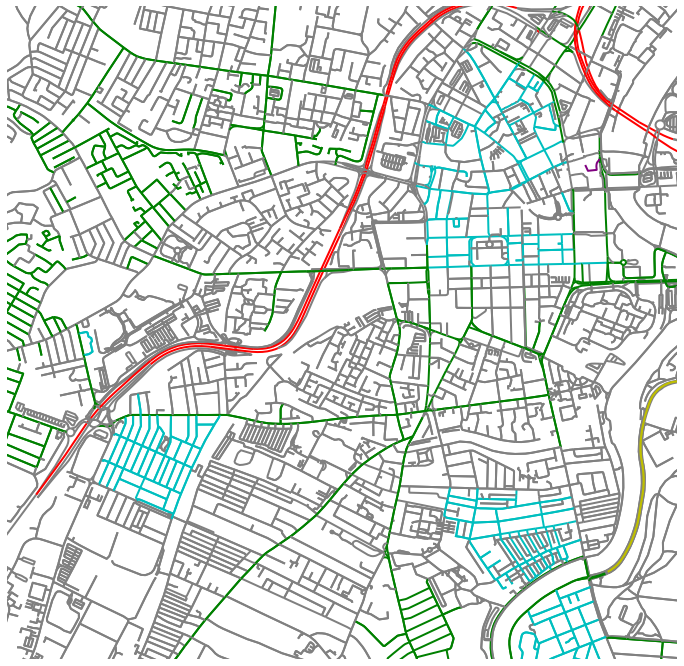

In [63]:
fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=0, node_color='b', 
                        edge_linewidth=2, file_format='png', edge_color=maxspeed_colours, bgcolor='w',
                        show=True)

## Road Type

In [64]:
df[df['highway'].apply(lambda o: isinstance(o,list))].head()

access area bridge                                           geometry  \
17     NaN  NaN    NaN  LINESTRING (310108.5216017482 6053116.29156261...   
92     NaN  NaN    NaN  LINESTRING (310190.3066893334 6053093.20480416...   
98     NaN  NaN    NaN  LINESTRING (310955.5381720872 6053740.47135856...   
102    NaN  NaN    yes  LINESTRING (309136.55783768 6052279.816553018,...   
103    NaN  NaN    NaN  LINESTRING (309136.55783768 6052279.816553018,...   

                    highway junction  key  lanes  length  maxspeed  \
17   [residential, footway]      NaN    0    NaN  67.805       NaN   
92      [residential, path]      NaN    0    NaN  35.252       NaN   
98   [residential, service]      NaN    0    NaN  99.851       NaN   
102        [footway, steps]      NaN    0    NaN  55.266       NaN   
103        [footway, steps]      NaN    0    NaN  18.724       NaN   

                                            name  oneway  \
17                               Matiltda Avenue   False   
92                                 Matilda Drive   False   
98   [Little May Street, Catherine Street North]   False   
102                                          NaN   False   
103                                          NaN   False   

                                osmid  ref service tunnel          u  \
17             [503113034, 503113035]  NaN     NaN    NaN  455032912   
92              [595950631, 38485639]  NaN     NaN    NaN  455033037   
98              [596983737, 26207083]  NaN     NaN    NaN  571343055   
102  [479459395, 44946725, 434882454]  NaN     NaN    NaN  569901266   
103            [434882456, 479459400]  NaN     NaN    NaN  569901266   

              v  width  
17   4006466553    NaN  
92   5678599990    NaN  
98     83770116    NaN  
102  4725546010    NaN  
103  4725546017    NaN

In [65]:
from collections import Counter
highway_counter = Counter()
highway_counter.update(df[df['highway'].apply(lambda o: not isinstance(o,list))]['highway'].values)
highway_counter.update([i for l in df[df['highway'].apply(lambda o:isinstance(o,list))]['highway'].values for i in l])
highway_counter

Counter({'tertiary': 378,
         'tertiary_link': 14,
         'trunk': 673,
         'residential': 4133,
         'unclassified': 1111,
         'pedestrian': 211,
         'service': 3787,
         'secondary': 553,
         'footway': 1613,
         'living_street': 391,
         'primary': 127,
         'motorway_link': 20,
         'path': 372,
         'cycleway': 108,
         'trunk_link': 75,
         'secondary_link': 20,
         'steps': 114,
         'corridor': 26,
         'track': 8,
         'motorway': 8,
         'primary_link': 2})

In [66]:
cmap=plt.cm.get_cmap('Paired', len(highway_counter))
highway_colourmap = {}
for (k,v),c in zip(highway_counter.most_common(),cmap.colors):
    highway_colourmap[k]=c
highway_colourmap

{'residential': array([0.65098039, 0.80784314, 0.89019608, 1.        ]),
 'service': array([0.65098039, 0.80784314, 0.89019608, 1.        ]),
 'footway': array([0.12156863, 0.47058824, 0.70588235, 1.        ]),
 'unclassified': array([0.12156863, 0.47058824, 0.70588235, 1.        ]),
 'trunk': array([0.69803922, 0.8745098 , 0.54117647, 1.        ]),
 'secondary': array([0.2       , 0.62745098, 0.17254902, 1.        ]),
 'living_street': array([0.2       , 0.62745098, 0.17254902, 1.        ]),
 'tertiary': array([0.98431373, 0.60392157, 0.6       , 1.        ]),
 'path': array([0.98431373, 0.60392157, 0.6       , 1.        ]),
 'pedestrian': array([0.89019608, 0.10196078, 0.10980392, 1.        ]),
 'primary': array([0.99215686, 0.74901961, 0.43529412, 1.        ]),
 'steps': array([0.99215686, 0.74901961, 0.43529412, 1.        ]),
 'cycleway': array([1.        , 0.49803922, 0.        , 1.        ]),
 'trunk_link': array([1.        , 0.49803922, 0.        , 1.        ]),
 'corridor': arr

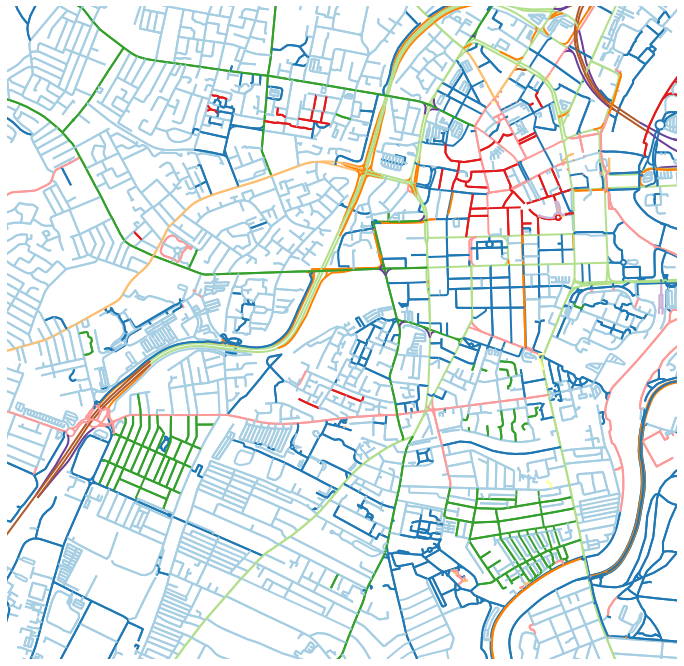

In [71]:
highway_colours = df['highway'].apply(lambda h: highway_colourmap[h[0]] 
                                      if isinstance(h,list) else highway_colourmap[h])
fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=0, node_color='b', 
                        edge_linewidth=2, file_format='png', edge_color=highway_colours, bgcolor='w', 
                        show=True)

## Varying road widths

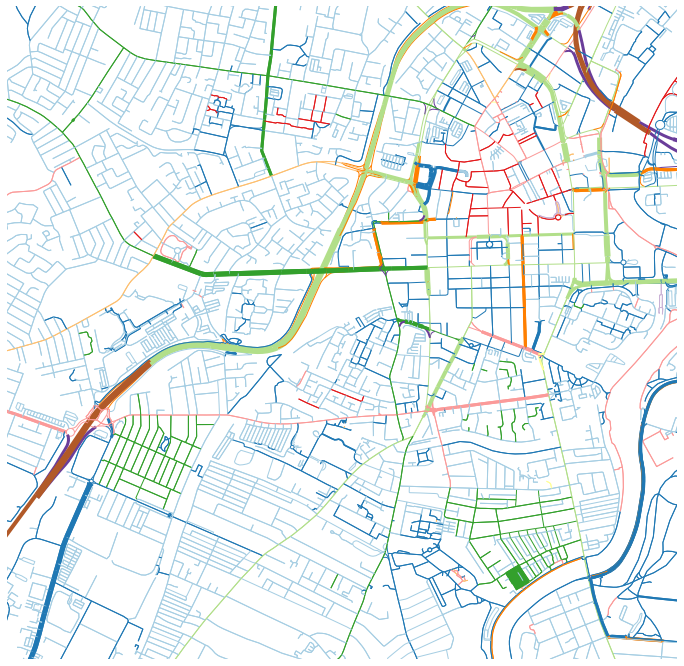

In [75]:
df['display_width'] = df[['width','lanes']].sum(axis=1).fillna(1.0)+1

fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=0, node_color='b', 
                        edge_linewidth=df['display_width'].values, file_format='png', edge_color=highway_colours, bgcolor='w', 
                        show=True)

# Graph Theory; what's the most connected junction around Farset?

In [76]:
nodes = []
for key,data in G.nodes(data=True):
    node = dict(key=key)
    node.update(data)
    nodes.append(node)
ndf = pd.DataFrame.from_records(nodes)
ndf.head()

highway         key        lat       lon       osmid  ref              x  \
0     NaN  3661561863  54.610067 -5.924350  3661561863  NaN  311150.841348   
1     NaN  3661561864  54.610366 -5.923007  3661561864  NaN  311238.942743   
2     NaN  3661561865  54.609526 -5.923706  3661561865  NaN  311189.887581   
3     NaN  3661561869  54.609923 -5.924270  3661561869  NaN  311155.335466   
4     NaN  3661561873  54.609238 -5.924231  3661561873  NaN  311154.707781   

              y  
0  6.055332e+06  
1  6.055361e+06  
2  6.055270e+06  
3  6.055316e+06  
4  6.055239e+06

### Extra Statistics provided by osmnx

In [77]:
centrality = ox.nx.betweenness_centrality(G,weight='length') 
ndf['centrality'] = ndf['key'].apply(lambda k: centrality[k])
ndf['centrality'].describe()

count    5423.000000
mean        0.006544
std         0.015663
min         0.000000
25%         0.000168
50%         0.001297
75%         0.005306
max         0.162575
Name: centrality, dtype: float64

In [78]:
cmap=plt.cm.get_cmap('jet')
from matplotlib import colors as colors
norm = colors.Normalize(vmin=ndf['centrality'].min(), vmax=ndf['centrality'].max())
centrality_size = ndf['centrality'].apply(norm)*128
centrality_colors = ndf['centrality'].apply(norm).apply(cmap).values

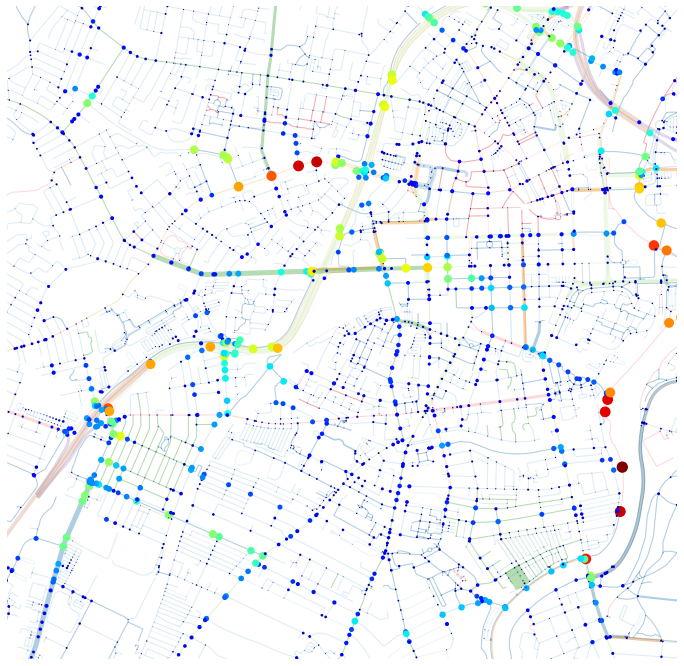

In [79]:
fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=centrality_size, node_color=centrality_colors, node_zorder=2,
                        edge_linewidth=df['display_width'].values, file_format='png', edge_color=highway_colours, edge_alpha=0.2, bgcolor='w', 
                        show=True)

In [80]:
basic_stats = ox.basic_stats(G, area=(2*dist)**2)
extended_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)

In [81]:
stats={**basic_stats,**extended_stats}
', '.join(stats.keys())

'n, m, k_avg, intersection_count, streets_per_node_avg, streets_per_node_counts, streets_per_node_proportion, edge_length_total, edge_length_avg, street_length_total, street_length_avg, street_segments_count, node_density_km, intersection_density_km, edge_density_km, street_density_km, circuity_avg, self_loop_proportion, clean_intersection_count, clean_intersection_density_km, avg_neighbor_degree, avg_neighbor_degree_avg, avg_weighted_neighbor_degree, avg_weighted_neighbor_degree_avg, degree_centrality, degree_centrality_avg, clustering_coefficient, clustering_coefficient_avg, clustering_coefficient_weighted, clustering_coefficient_weighted_avg, pagerank, pagerank_max_node, pagerank_max, pagerank_min_node, pagerank_min, eccentricity, diameter, radius, center, periphery, closeness_centrality, closeness_centrality_avg, betweenness_centrality, betweenness_centrality_avg'

In [82]:
pd.Series({k:v for k,v in stats.items() if not isinstance(v,dict)})

n                                              5423
m                                             13354
k_avg                                       4.92495
intersection_count                             4324
streets_per_node_avg                        2.71658
edge_length_total                            725970
edge_length_avg                             54.3635
street_length_total                          404480
street_length_avg                           55.4006
street_segments_count                          7301
node_density_km                             338.938
intersection_density_km                      270.25
edge_density_km                             45373.1
street_density_km                             25280
circuity_avg                            1.28998e-05
self_loop_proportion                     0.00381908
clean_intersection_count                       None
clean_intersection_density_km                  None
avg_neighbor_degree_avg                     2.74519
avg_weighted

In [83]:
pd.Series({k:len(v) for k,v in stats.items() if isinstance(v,dict)})

streets_per_node_counts               7
streets_per_node_proportion           7
avg_neighbor_degree                5423
avg_weighted_neighbor_degree       5423
degree_centrality                  5423
clustering_coefficient             5423
clustering_coefficient_weighted    5423
pagerank                           5423
eccentricity                       5371
closeness_centrality               5423
betweenness_centrality             5423
dtype: int64

In [84]:
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
max_node, max_bc

(2052785844, 0.16257464933780527)

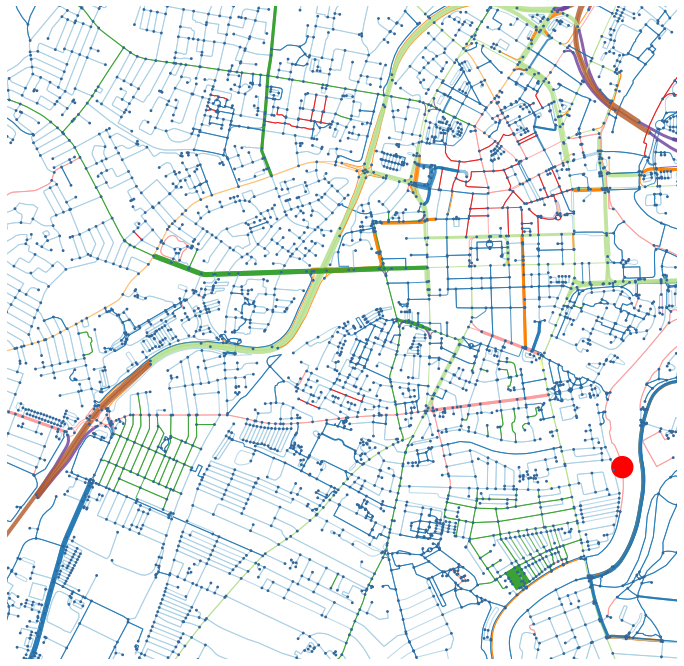

(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x127555b00>)

In [85]:
nc = ['r' if node==max_node else '#336699' for node in G.nodes()]
ns = [500 if node==max_node else 8 for node in G.nodes()]
ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2, show=True, bbox=bbox_proj, fig_height=figsize, margin=0, 
            edge_linewidth=df['display_width'].values, file_format='png', edge_color=highway_colours, edge_alpha=0.8, bgcolor='w',)

# How Central is Farset? What are the travel times?

In [86]:
center_node = 2698751105

farset_stats = pd.Series({k:v[center_node] for k,v in stats.items() if isinstance(v,dict) and center_node in v})
farset_stats

avg_neighbor_degree                   2.333333
avg_weighted_neighbor_degree          0.068526
degree_centrality                     0.001107
clustering_coefficient                0.000000
clustering_coefficient_weighted       0.000000
pagerank                              0.000266
eccentricity                       3751.353000
closeness_centrality                  0.000511
betweenness_centrality                0.006214
dtype: float64

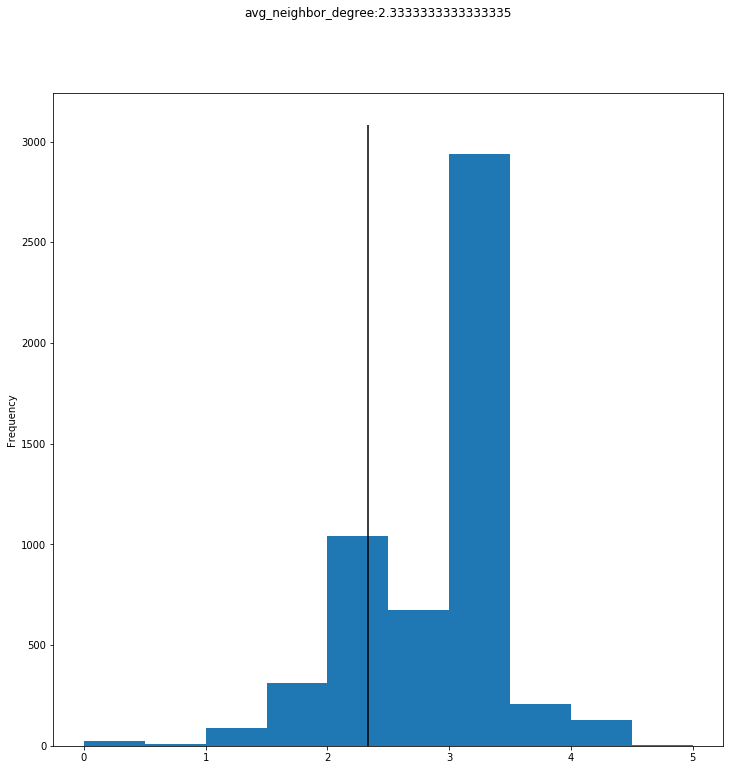

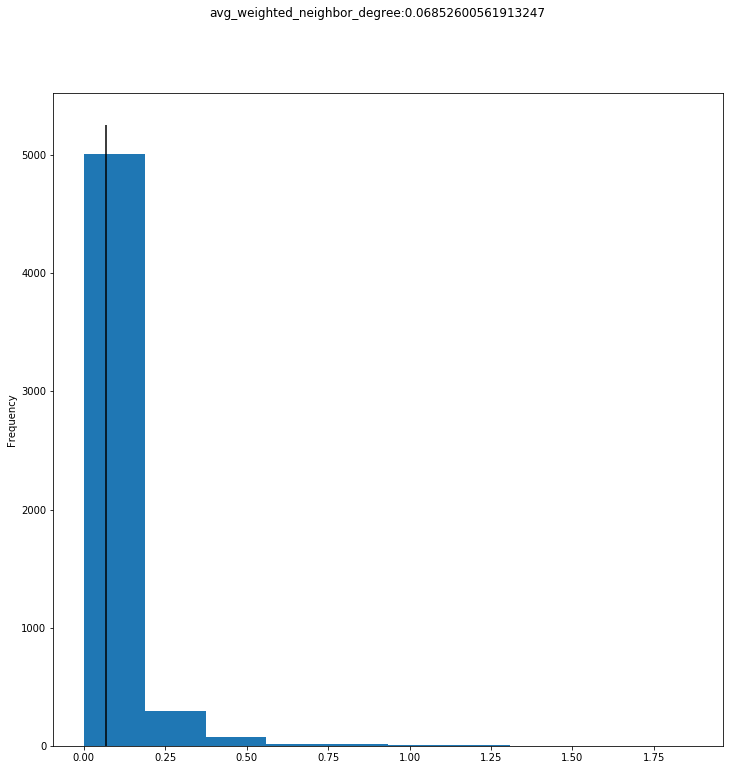

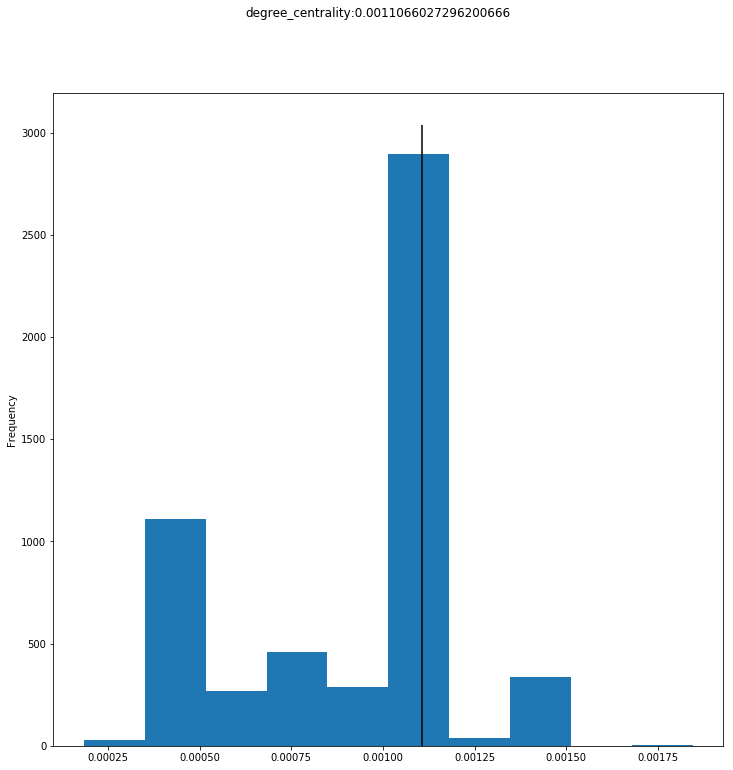

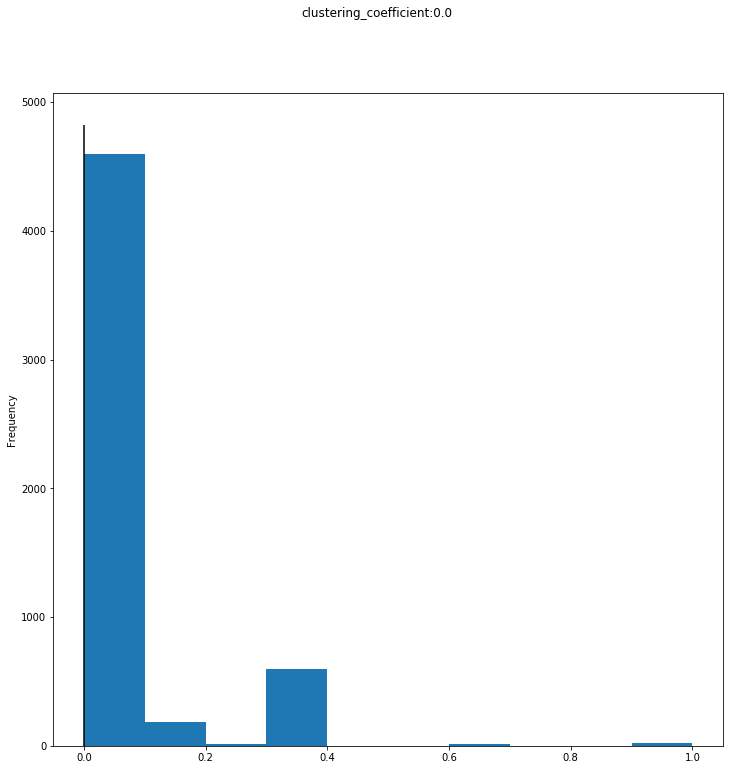

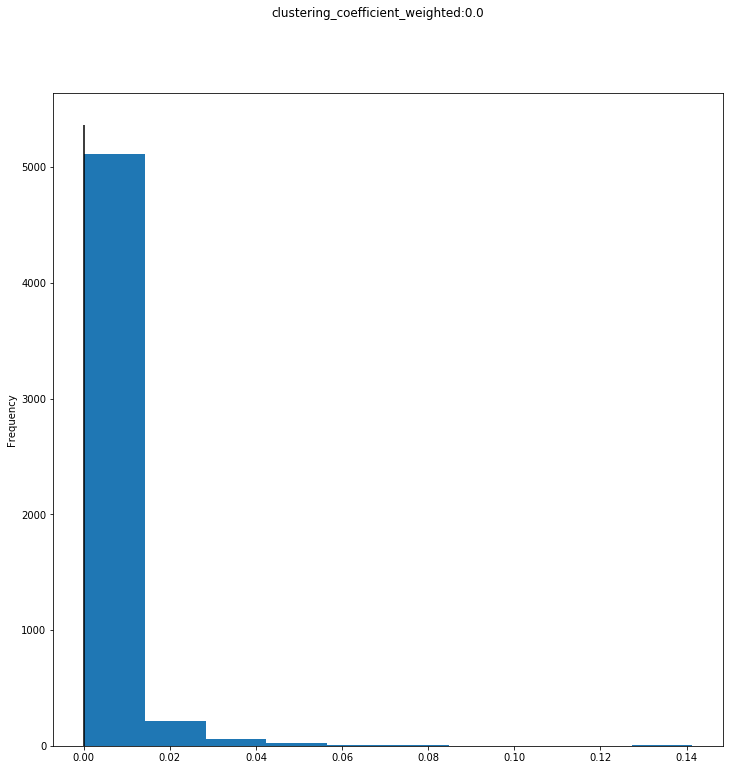

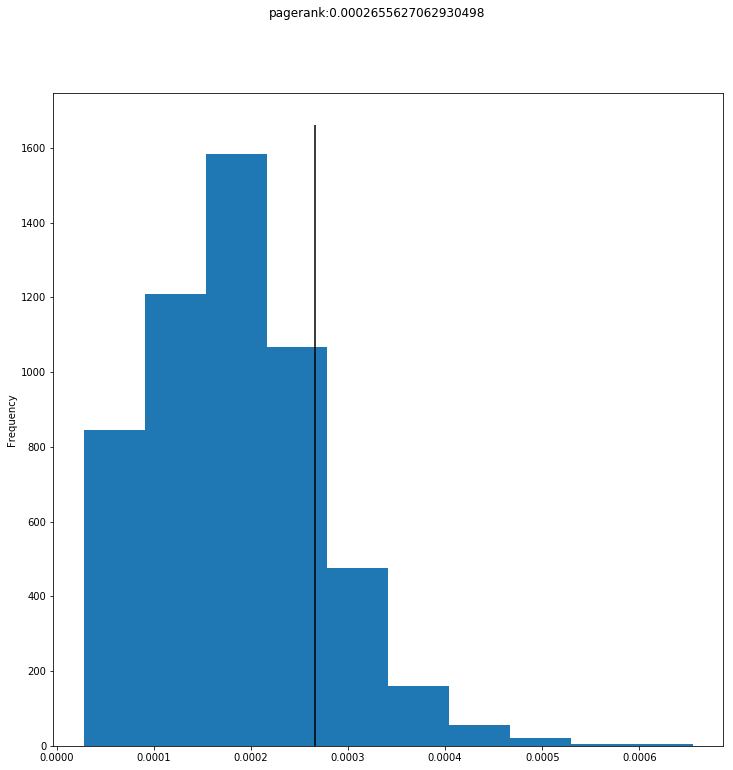

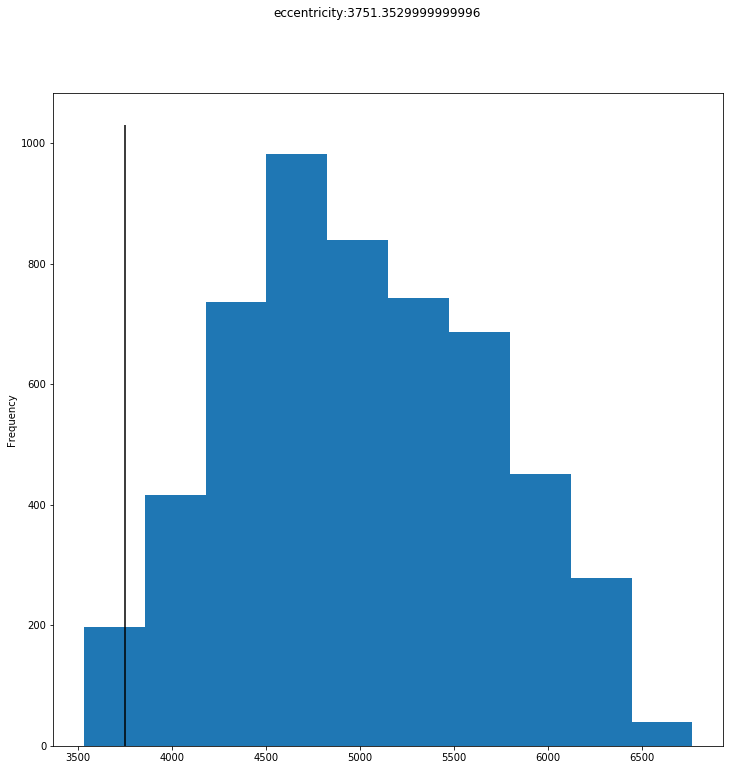

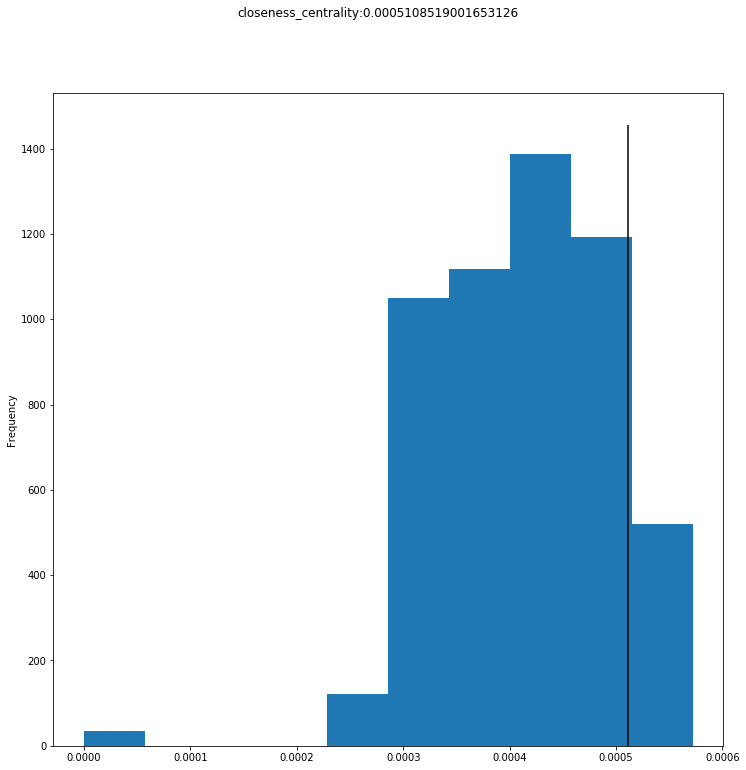

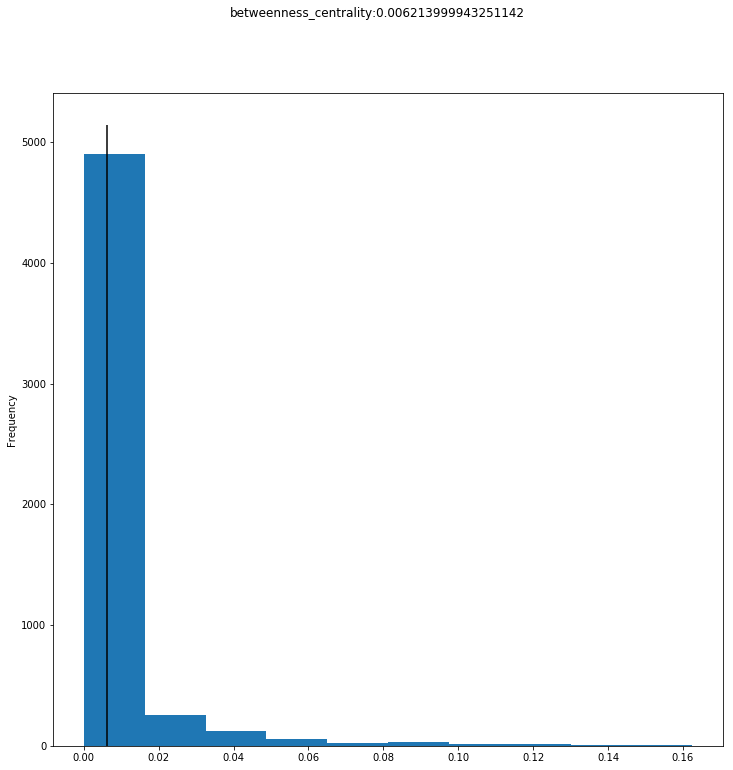

In [87]:
for measure, farsets in farset_stats.iteritems():
    f,ax = plt.subplots(figsize=(figsize,figsize))
    s=pd.Series(stats[measure])
    s.plot.hist(ax=ax)
    ylims = dict(zip(('ymin','ymax'),ax.get_ylim()))
    ax.vlines(farsets,**ylims)
    f.suptitle("{}:{}".format(measure,farsets))

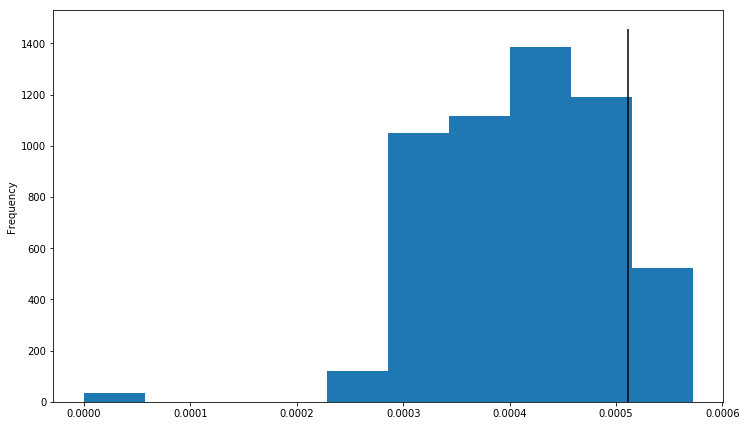

In [88]:
f,ax = plt.subplots(figsize = (figsize,0.6*figsize))
s=pd.Series(stats['closeness_centrality'])
s.plot.hist(ax=ax)
ylims = dict(zip(('ymin','ymax'),ax.get_ylim()))
ax.vlines(farset_stats['closeness_centrality'],**ylims)

In [95]:
s.rank(pct=True, ascending=False)[center_node]

0.10724768570783473

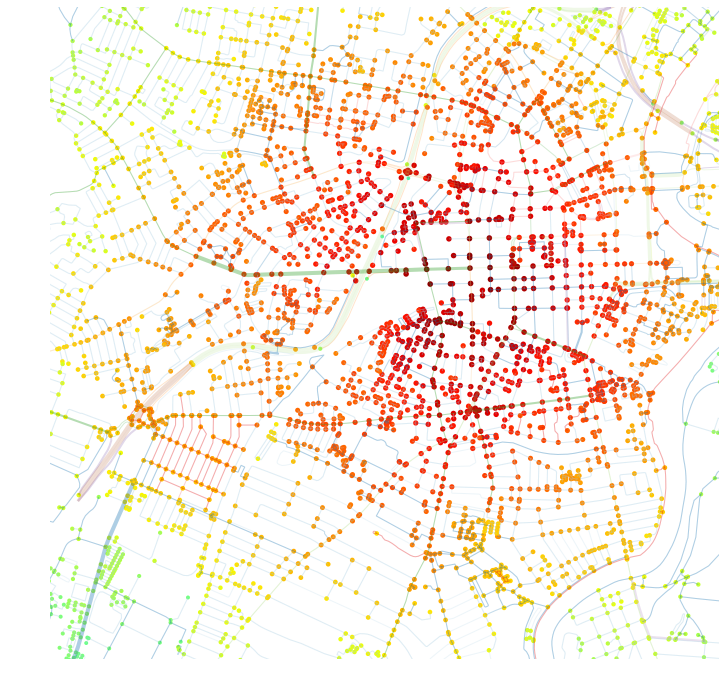

In [96]:
ndf['closeness_centrality'] = ndf['key'].apply(lambda k: extended_stats['closeness_centrality'][k] if k in extended_stats['closeness_centrality'] else np.nan)

cmap=plt.cm.get_cmap('jet')
from matplotlib import colors as colors
norm = colors.Normalize(vmin=ndf['closeness_centrality'].min(), vmax=ndf['closeness_centrality'].max())
_size = ndf['closeness_centrality'].apply(norm)*32
_colours = ndf['closeness_centrality'].apply(norm).apply(cmap).values
fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=_size, node_color=_colours, 
                        edge_linewidth=df['display_width'].values, file_format='png', edge_color=highway_colours, edge_alpha=0.2, bgcolor='w', 
                        show=True)

In [97]:
farset_paths = ox.nx.single_source_dijkstra_path_length(G, center_node, weight='length')


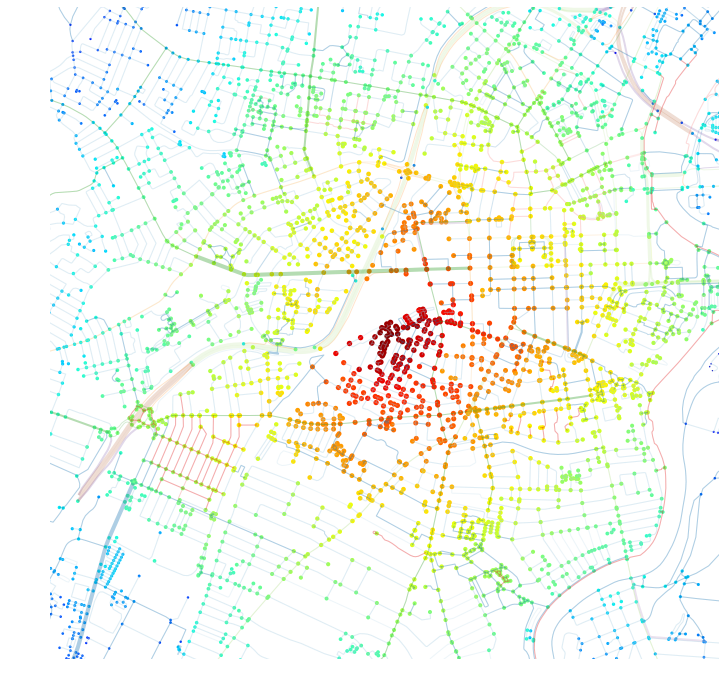

In [98]:
ndf['fsl_distance'] = ndf['key'].apply(lambda k: farset_paths[k] if k in farset_paths else None)
ndf['fsl_distance_invert'] = -ndf['fsl_distance']
norm = colors.Normalize(vmin=ndf['fsl_distance_invert'].min(), vmax=ndf['fsl_distance_invert'].max())
distance_size = ndf['fsl_distance_invert'].apply(norm)*32
distance_colours = ndf['fsl_distance_invert'].apply(norm).apply(cmap).values
fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=distance_size, node_color=distance_colours, 
                        edge_linewidth=df['display_width'].values, file_format='png', edge_color=highway_colours, edge_alpha=0.2, bgcolor='w', 
                    )


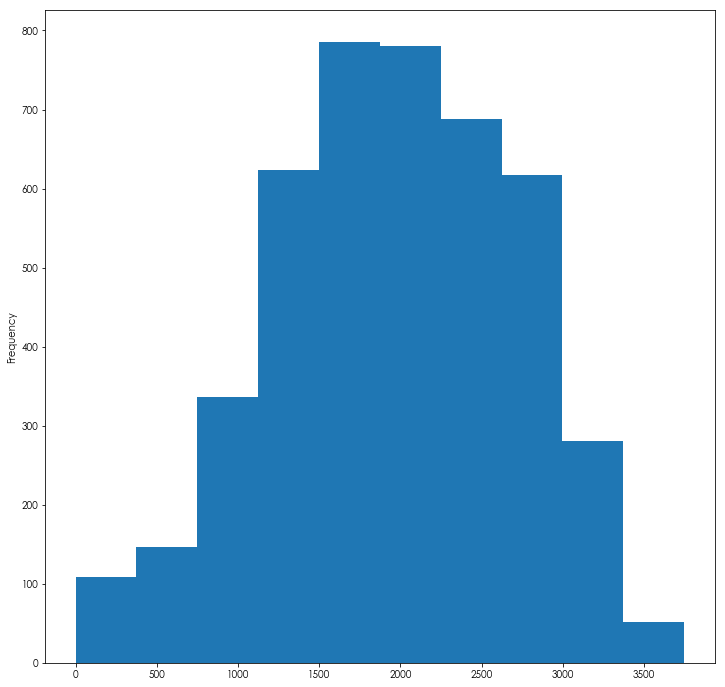

In [99]:
ndf['fsl_distance'].plot.hist(figsize=(figsize,figsize))

In [100]:
# add an edge attribute for time in minutes required to traverse each edge
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 5 #walking speed in km/hour
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='jet', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = ox.nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]

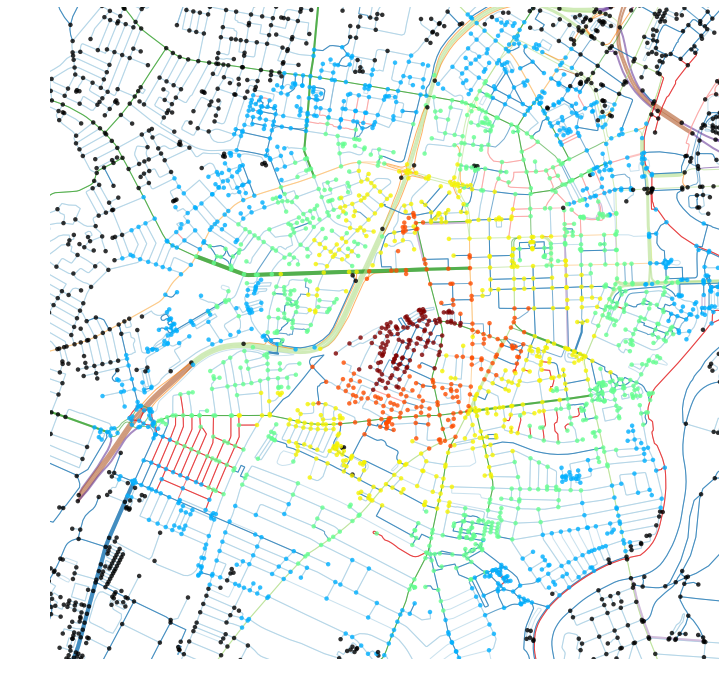

In [101]:
fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, node_alpha=0.8, node_zorder=2,
                        bbox=bbox_proj, fig_height=figsize, margin=0, edge_linewidth=df['display_width'].values, 
                        file_format='png', edge_alpha=0.6, bgcolor='w',
                        edge_color=highway_colours)

In [102]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = ox.nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
    

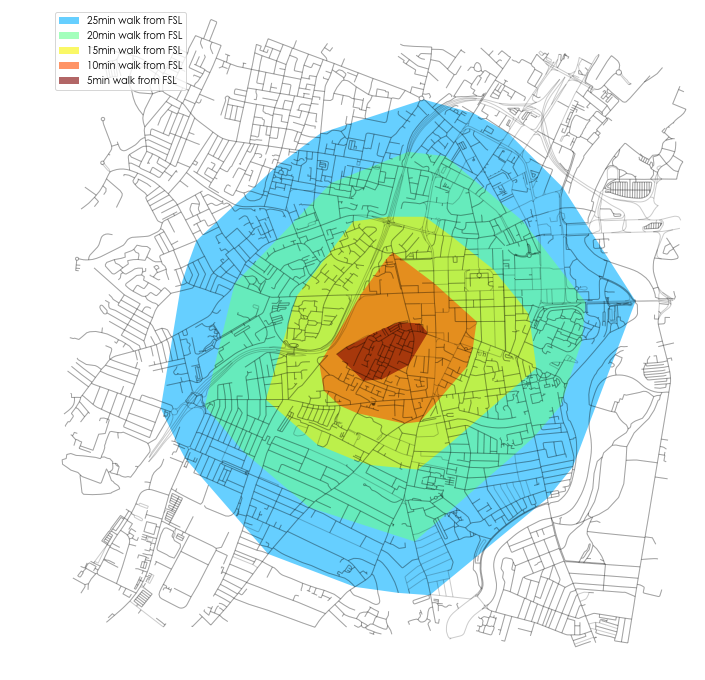

In [109]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, fig_height=figsize, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
handles = []
labels=[]
for polygon, fc, trip_time in zip(isochrone_polys, iso_colors, reversed(trip_times)):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1, label="{}min walk from FSL".format(trip_time))
    ax.add_patch(patch)
    handles.append(patch)
plt.legend(handles=handles)
plt.show()

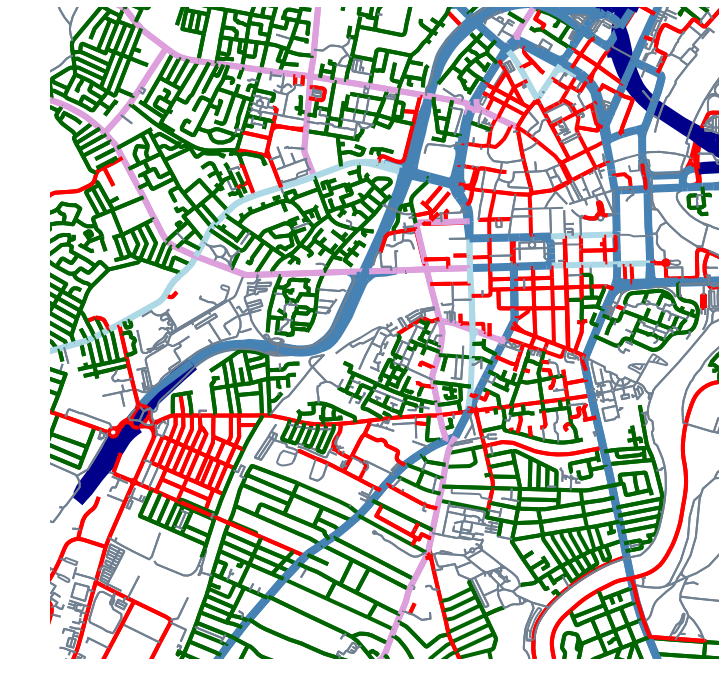

In [104]:
def highway_map(h_string):

    if h_string in ['footway', 'steps', 'pedestrian', 'service', 'path', 'track']:
        width = 1
        colour = 'slategrey'
    elif h_string in ['residential','living street']:
        width = 2
        colour = 'darkgreen'
    elif h_string in ['motorway','motorway_link']:
        width = 6
        colour = 'darkblue'
    elif h_string in ['trunk','trunk_link']:
        width = 4
        colour = 'steelblue'
    elif h_string in ['primary','primary_link']:
        width = 3
        colour = 'lightblue'
    elif h_string in ['secondary','secondary_link']:
        width = 3
        colour = 'plum'
    else:
        #print("No Match for {}".format(h_string))
        width=-1
        colour=None
        
    return width, colour

# ascribe street widths in pixels according to edge type
ew = []
ec = []
highways = []

for u, v, key, data in G.edges(keys=True, data=True):
    colour = None
    width = 0
    if isinstance(data['highway'], list):
        for h_string in data['highway']:
            _w,_c = highway_map(h_string)
            if _w > width:
                width,colour = _w, _c
    else:
        width, colour = highway_map(data['highway'])
    if width == -1:
        width = 2
        colour = 'r'
    if colour is None:
        colour = '#47494c'
    highways.append(data['highway'])
    ew.append(width*2)
    ec.append(colour)
    
# plot the graph and save it to disk
fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=0, 
                        edge_linewidth=ew, file_format='png', edge_color=ec, bgcolor='w', 
                        show=True)

In [ ]:
raise ValueError("Stop Doing That")
%matplotlib inline
ox.config(log_file=True, log_console=True, use_cache=True)


def highway_map(h_string):

    if h_string in ['footway', 'steps', 'pedestrian', 'service', 'footway', 'path', 'track']:
        width = 1
        colour = 'slategrey'
    elif h_string in ['residential']:
        width = 2
        colour = 'darkgreen'
    elif h_string in ['motorway','motorway_link']:
        width = 6
        colour = 'darkblue'
    elif h_string in ['trunk','trunk_link']:
        width = 4
        colour = 'steelblue'
    elif h_string in ['primary','primary_link']:
        width = 3
        colour = 'lightblue'
    else:
        width=-1
        colour=None
        
    return width, colour

dist = 805 #one half mile converted to meters
dist*=4

# create a list of place names, center lat-long points, and network types
places = [#['sf', (37.793897, -122.402189), 'drive_service'],
          #['portland', (45.517309, -122.682138), 'drive_service'],
          #['irvine', (33.694981, -117.841375), 'drive_service'],
          #['rome', (41.901336, 12.471831), 'all'],
          ['belfast', (54.5973, -5.9301), 'all'],
          #['farset', (54.592696, -5.940655), 'all']
         ]
highways = []
for name, point, nt in places:
    print(name, point)
    
    # get the network within 1/2 mile north, south, east, and west of the point, then project to UTM
    _G = ox.graph_from_point(point, distance=dist, distance_type='bbox', network_type=nt, truncate_by_edge=True)
    _G = ox.project_graph(G)
    
    # ascribe street widths in pixels according to edge type
    ew = []
    ec = []
    for u, v, key, data in _G.edges(keys=True, data=True):
        colour = None
        width = 0
        if isinstance(data['highway'], list):
            for h_string in data['highway']:
                _w,_c = highway_map(h_string)
                if _w > width:
                    width,colour = _w, _c

        width, colour = highway_map(data['highway'])
        if width == -1:
            width = 2
            colour = 'r'
        highways.append(data['highway'])
        ew.append(width*2)
        ec.append('w')
    
    # create the plot's bounding box in meters to limit the plot to the square mile bounding box requested
    # this is only necessary when truncate_by_edge=True to prevent display of nodes/edges that extend beyond bounding box
    _bbox_proj = ox.bbox_from_point(point, dist, project_utm=True)
    
    # plot the graph and save it to disk
    fig, ax = ox.plot_graph(_G, bbox=_bbox_proj, fig_height=figsize, margin=0, node_size=0, 
                            edge_linewidth=ew, file_format='png', edge_color=ec, bgcolor='#47494c', 
                            show=True, save=True, filename='gs_{}'.format(name))
